In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df=pd.read_csv("weatherHistory.csv",na_values=['-999'])
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
df=df[['Formatted Date','Temperature (C)','Humidity','Pressure (millibars)']]
df.columns=['Date & Time','Temp','RH','press']
df.head()

,Date & Time,Temp,RH,press
0,2006-04-01 00:00:00.000 +0200,9.472222,0.89,1015.13
1,2006-04-01 01:00:00.000 +0200,9.355556,0.86,1015.63
2,2006-04-01 02:00:00.000 +0200,9.377778,0.89,1015.94
3,2006-04-01 03:00:00.000 +0200,8.288889,0.83,1016.41
4,2006-04-01 04:00:00.000 +0200,8.755556,0.83,1016.51


In [4]:
df.set_index('Date & Time',inplace=True)

In [5]:
df.index=pd.to_datetime(df.index,utc=True)

In [6]:
df

,Temp,RH,press
Date & Time,,,
2006-03-31 22:00:00+00:00,9.472222,0.89,1015.13
2006-03-31 23:00:00+00:00,9.355556,0.86,1015.63
2006-04-01 00:00:00+00:00,9.377778,0.89,1015.94
2006-04-01 01:00:00+00:00,8.288889,0.83,1016.41
2006-04-01 02:00:00+00:00,8.755556,0.83,1016.51
...,...,...,...
2016-09-09 17:00:00+00:00,26.016667,0.43,1014.36
2016-09-09 18:00:00+00:00,24.583333,0.48,1015.16
2016-09-09 19:00:00+00:00,22.038889,0.56,1015.66


## Temperature


In [7]:
Temp = df.drop(['RH', 'press'], axis=1)
Temp

,Temp
Date & Time,
2006-03-31 22:00:00+00:00,9.472222
2006-03-31 23:00:00+00:00,9.355556
2006-04-01 00:00:00+00:00,9.377778
2006-04-01 01:00:00+00:00,8.288889
2006-04-01 02:00:00+00:00,8.755556
...,...
2016-09-09 17:00:00+00:00,26.016667
2016-09-09 18:00:00+00:00,24.583333
2016-09-09 19:00:00+00:00,22.038889


<AxesSubplot: xlabel='Date & Time'>

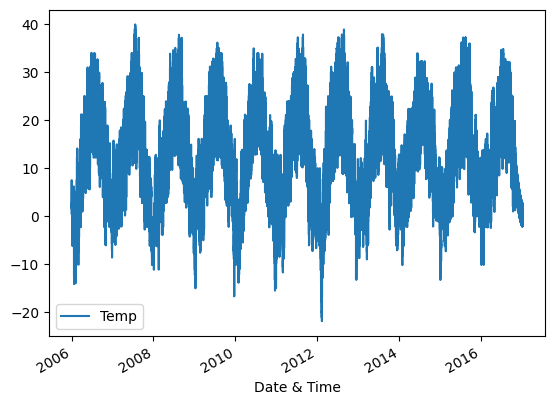

In [8]:
Temp.plot()

<AxesSubplot: ylabel='Frequency'>

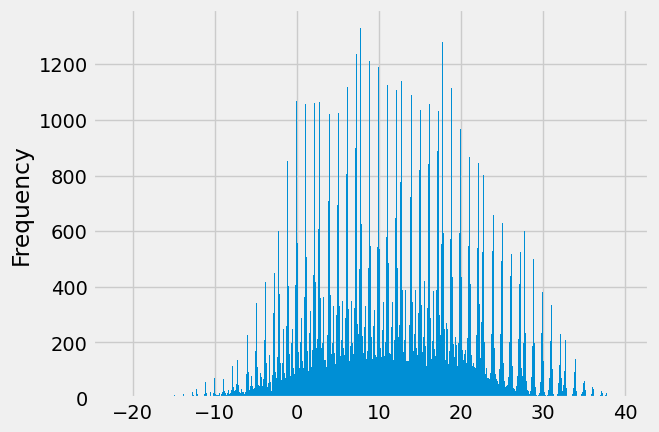

In [48]:
Temp['Temp'].plot(kind='hist', bins=500)

In [9]:
Temp['Hour']=Temp.index.hour
Temp['Dayofweek']=Temp.index.day_of_week
Temp['Month']=Temp.index.month
Temp['Year']=Temp.index.year
Temp['quarter'] = Temp.index.quarter
Temp['dayofyear'] = Temp.index.dayofyear
Temp['dayofmonth'] = Temp.index.day

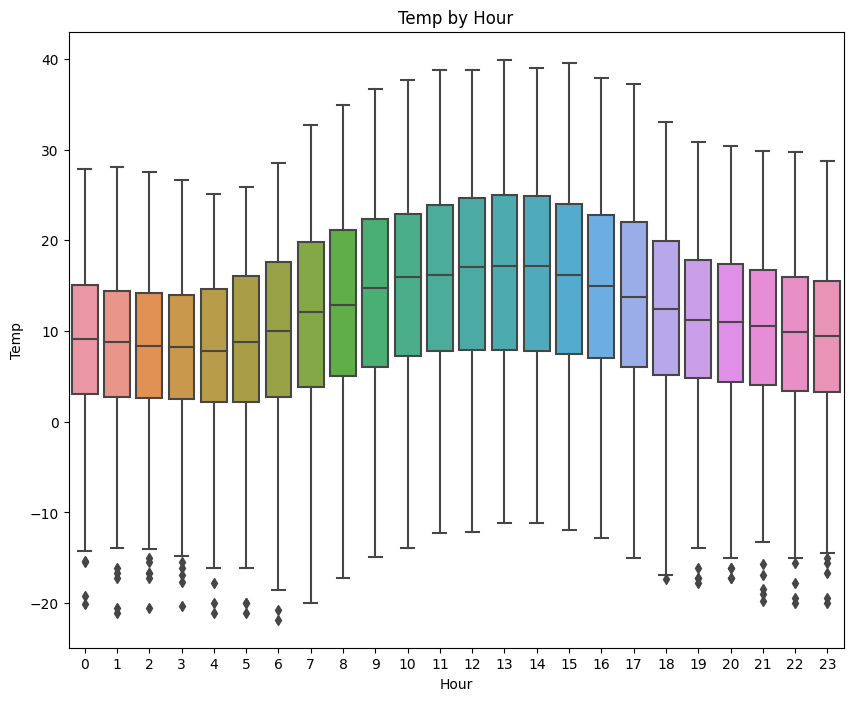

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Temp, x='Hour', y='Temp')
ax.set_title('Temp by Hour')
plt.show()

In [12]:
train1=Temp.loc[Temp.index<'2014-01-01']
test1=Temp.loc[Temp.index>'2014-01-01']

In [15]:
FEATURES = [ 'Hour', 'Dayofweek', 'Month', 'Year', 'quarter','dayofyear','dayofmonth']
TARGET = 'Temp'

X_train1= train1[FEATURES]
y_train1 = train1[TARGET]

X_test1 = test1[FEATURES]
y_test1 = test1[TARGET]

In [16]:
reg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg1.fit(X_train1, y_train1,
        eval_set=[(X_train1, y_train1), (X_test1, y_test1)],
        verbose=100)

[12:15:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.82671	validation_1-rmse:14.61846
[100]	validation_0-rmse:7.30746	validation_1-rmse:7.00102
[200]	validation_0-rmse:5.14385	validation_1-rmse:4.78476
[300]	validation_0-rmse:4.49129	validation_1-rmse:4.14156
[400]	validation_0-rmse:4.26046	validation_1-rmse:3.95920
[500]	validation_0-rmse:4.15733	validation_1-rmse:3.90443
[600]	validation_0-rmse:4.10071	validation_1-rmse:3.89267
[656]	validation_0-rmse:4.07732	validation_1-rmse:3.89360


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

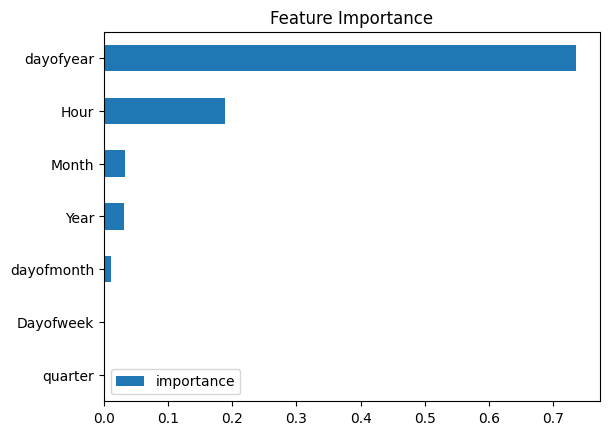

In [18]:
fi = pd.DataFrame(data=reg1.feature_importances_,
             index=reg1.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [22]:
test1['prediction'] = reg1.predict(X_test1)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\653660318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['prediction'] = reg1.predict(X_test1)


In [24]:
score = np.sqrt(mean_squared_error(test1['Temp'], test1['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3.89


In [26]:
test1['error'] = np.abs(test1[TARGET] - test1['prediction'])
test1['date'] = test1.index.date
test1.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\925290086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['error'] = np.abs(test1[TARGET] - test1['prediction'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\925290086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['date'] = test1.index.date


date
2014-12-31    10.502320
2016-02-09     9.765212
2016-04-25     9.742111
2015-09-17     9.188666
2014-10-14     9.135289
2016-02-14     9.063542
2014-01-20     8.740954
2014-02-11     8.628175
2015-11-11     8.566000
2016-02-15     8.446892
Name: error, dtype: float64

## Humidity

In [55]:
Humidity = df.drop(['Temp', 'press'], axis=1)
Humidity

,RH
Date & Time,
2006-03-31 22:00:00+00:00,0.89
2006-03-31 23:00:00+00:00,0.86
2006-04-01 00:00:00+00:00,0.89
2006-04-01 01:00:00+00:00,0.83
2006-04-01 02:00:00+00:00,0.83
...,...
2016-09-09 17:00:00+00:00,0.43
2016-09-09 18:00:00+00:00,0.48
2016-09-09 19:00:00+00:00,0.56


<AxesSubplot: ylabel='Frequency'>

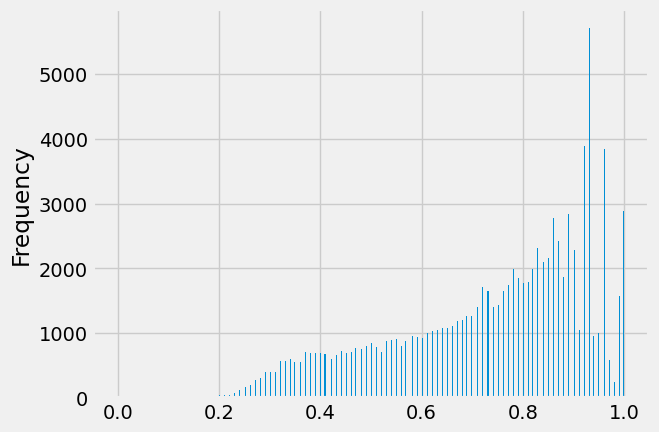

In [56]:
Humidity['RH'].plot(kind='hist', bins=500)

In [59]:
Humidity['Hour']=Humidity.index.hour
Humidity['Dayofweek']=Humidity.index.day_of_week
Humidity['Month']=Humidity.index.month
Humidity['Year']=Humidity.index.year
Humidity['quarter'] = Humidity.index.quarter
Humidity['dayofyear'] = Humidity.index.dayofyear
Humidity['dayofmonth'] = Humidity.index.day

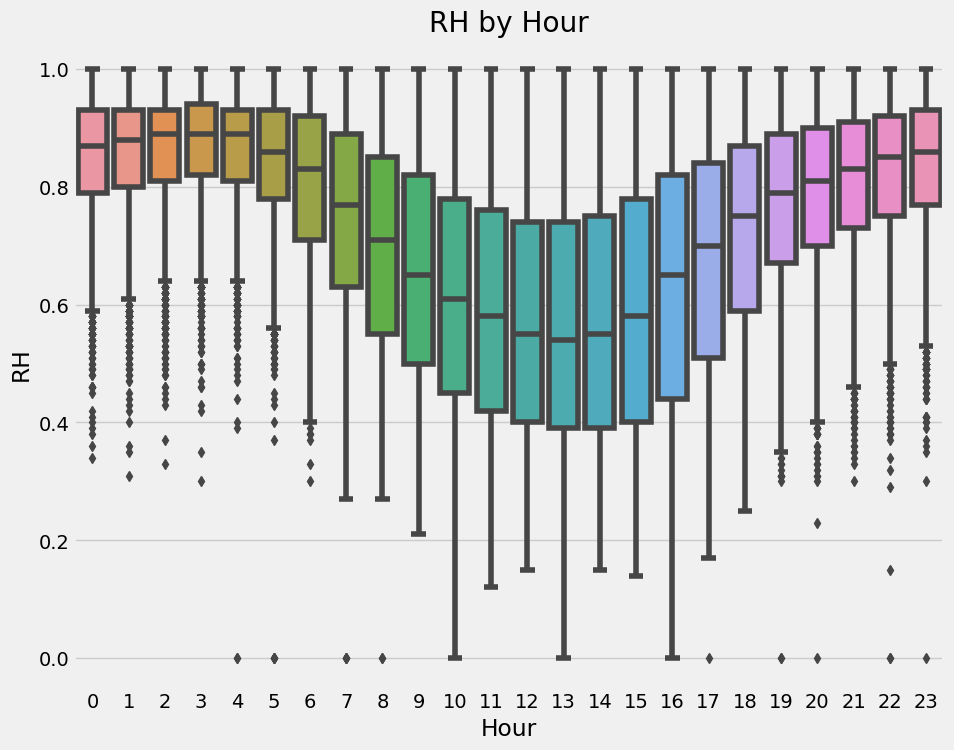

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Humidity, x='Hour', y='RH')
ax.set_title('RH by Hour')
plt.show()

In [61]:
train2=Humidity.loc[Humidity.index<'2014-01-01']
test2=Humidity.loc[Humidity.index>='2014-01-01']

In [62]:
FEATURES = [ 'Hour', 'Dayofweek', 'Month', 'Year', 'quarter','dayofyear','dayofmonth']
TARGET = 'RH'

X_train2= train2[FEATURES]
y_train2 = train2[TARGET]

X_test2 = test2[FEATURES]
y_test2 = test2[TARGET]

In [63]:
reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg2.fit(X_train2, y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        verbose=100)

[12:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.30122	validation_1-rmse:0.30909
[100]	validation_0-rmse:0.17774	validation_1-rmse:0.17809
[200]	validation_0-rmse:0.14598	validation_1-rmse:0.14091
[300]	validation_0-rmse:0.13653	validation_1-rmse:0.13220
[400]	validation_0-rmse:0.13182	validation_1-rmse:0.13032
[457]	validation_0-rmse:0.13008	validation_1-rmse:0.13058


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

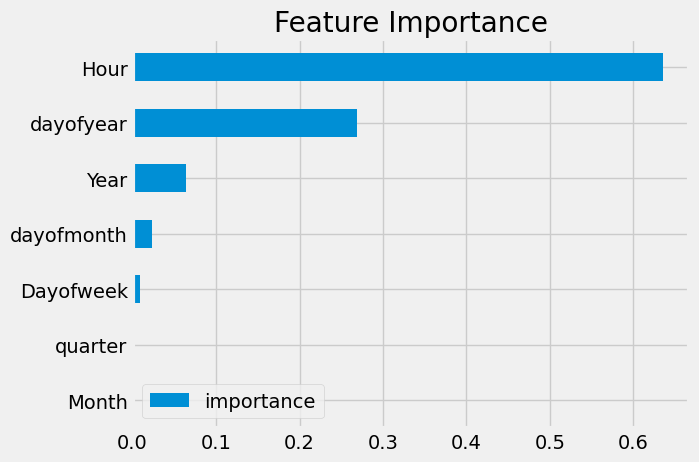

In [64]:
fi = pd.DataFrame(data=reg2.feature_importances_,
             index=reg2.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [65]:
test2['prediction'] = reg2.predict(X_test2)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\3916782767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['prediction'] = reg2.predict(X_test2)


In [66]:
score = np.sqrt(mean_squared_error(test2['RH'], test2['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.13


In [67]:
test2['error'] = np.abs(test2[TARGET] - test2['prediction'])
test2['date'] = test2.index.date
test2.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\4054788015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['error'] = np.abs(test2[TARGET] - test2['prediction'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\4054788015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['date'] = test2.index.date


date
2014-03-12    0.302088
2015-08-21    0.288379
2016-07-17    0.284535
2016-08-22    0.279276
2015-08-20    0.273379
2014-03-13    0.270838
2014-07-11    0.267035
2015-09-05    0.262962
2015-09-10    0.261074
2014-09-15    0.259502
Name: error, dtype: float64

## Pressure

In [68]:
Pres = df.drop(['RH', 'Temp'], axis=1)
Pres

,press
Date & Time,
2006-03-31 22:00:00+00:00,1015.13
2006-03-31 23:00:00+00:00,1015.63
2006-04-01 00:00:00+00:00,1015.94
2006-04-01 01:00:00+00:00,1016.41
2006-04-01 02:00:00+00:00,1016.51
...,...
2016-09-09 17:00:00+00:00,1014.36
2016-09-09 18:00:00+00:00,1015.16
2016-09-09 19:00:00+00:00,1015.66


In [69]:
Pres= Pres[Pres != 0].dropna()

In [72]:
Pres

,press
Date & Time,
2006-03-31 22:00:00+00:00,1015.13
2006-03-31 23:00:00+00:00,1015.63
2006-04-01 00:00:00+00:00,1015.94
2006-04-01 01:00:00+00:00,1016.41
2006-04-01 02:00:00+00:00,1016.51
...,...
2016-09-09 17:00:00+00:00,1014.36
2016-09-09 18:00:00+00:00,1015.16
2016-09-09 19:00:00+00:00,1015.66


In [74]:
Pres.index

DatetimeIndex(['2006-03-31 22:00:00+00:00', '2006-03-31 23:00:00+00:00',
               '2006-04-01 00:00:00+00:00', '2006-04-01 01:00:00+00:00',
               '2006-04-01 02:00:00+00:00', '2006-04-01 03:00:00+00:00',
               '2006-04-01 04:00:00+00:00', '2006-04-01 05:00:00+00:00',
               '2006-04-01 06:00:00+00:00', '2006-04-01 07:00:00+00:00',
               ...
               '2016-09-09 12:00:00+00:00', '2016-09-09 13:00:00+00:00',
               '2016-09-09 14:00:00+00:00', '2016-09-09 15:00:00+00:00',
               '2016-09-09 16:00:00+00:00', '2016-09-09 17:00:00+00:00',
               '2016-09-09 18:00:00+00:00', '2016-09-09 19:00:00+00:00',
               '2016-09-09 20:00:00+00:00', '2016-09-09 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date & Time', length=95165, freq=None)

<AxesSubplot: xlabel='Date & Time'>

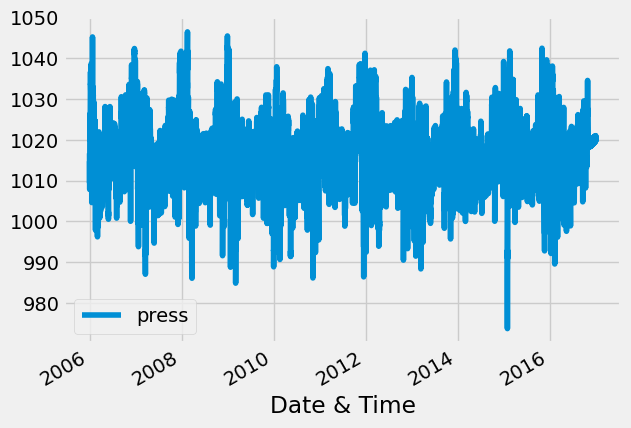

In [76]:
Pres.plot()

<AxesSubplot: ylabel='Frequency'>

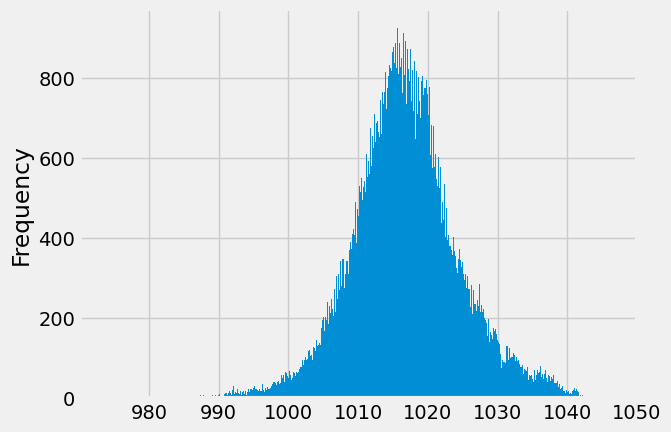

In [75]:
Pres['press'].plot(kind='hist', bins=500)

<AxesSubplot: title={'center': 'Outliers'}, xlabel='Date & Time'>

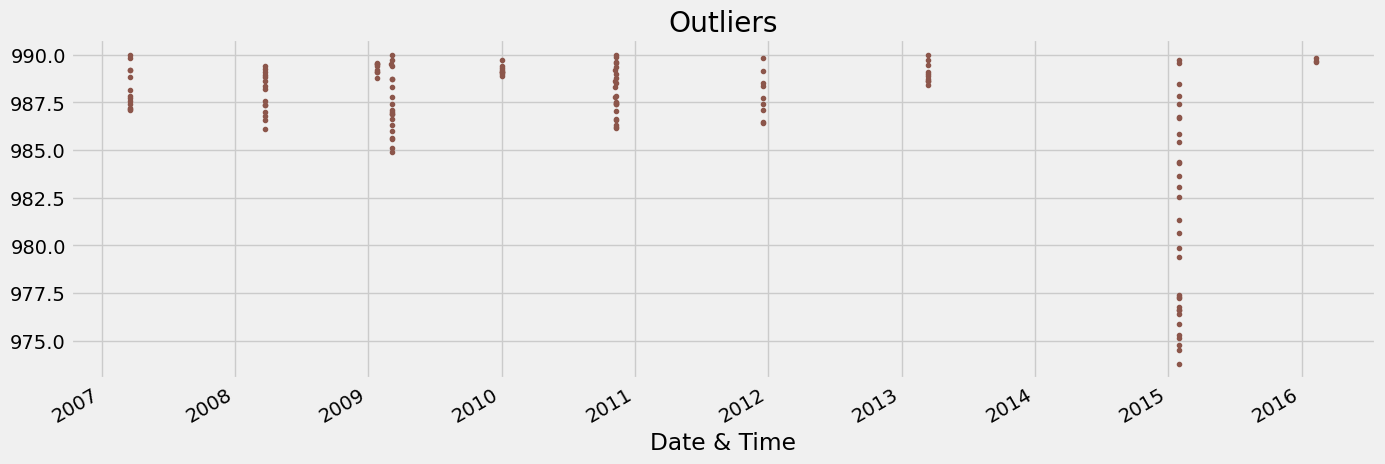

In [83]:
Pres.query('press <990')['press'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [84]:
Pres = Pres.query('press > 990').copy()

In [85]:
Pres['Hour']=Pres.index.hour
Pres['Dayofweek']=Pres.index.day_of_week
Pres['Month']=Pres.index.month
Pres['Year']=Pres.index.year
Pres['quarter'] = Pres.index.quarter
Pres['dayofyear'] = Pres.index.dayofyear
Pres['dayofmonth'] = Pres.index.day


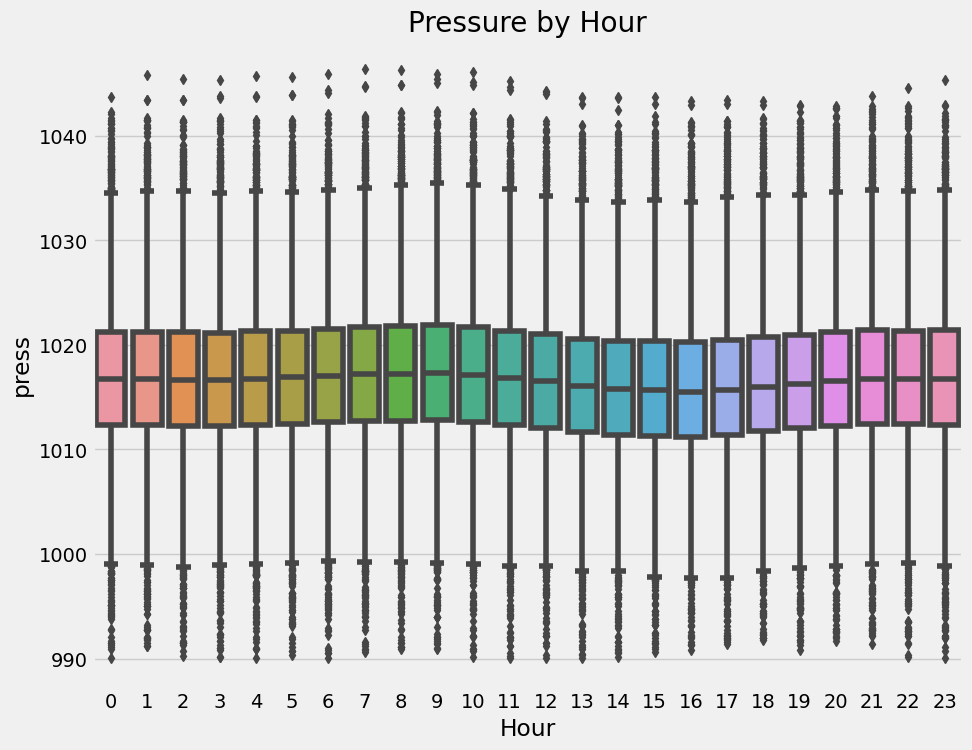

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=Pres, x='Hour', y='press')
ax.set_title('Pressure by Hour')
plt.show()

In [87]:
train3=Pres.loc[Pres.index<'2014-01-01']
test3=Pres.loc[Pres.index>='2014-01-01']

In [88]:
FEATURES = [ 'Hour', 'Dayofweek', 'Month', 'Year', 'quarter','dayofyear','dayofmonth']
TARGET = 'press'

X_train3= train3[FEATURES]
y_train3 = train3[TARGET]

X_test3 = test3[FEATURES]
y_test3 = test3[TARGET]

In [89]:
reg3 = xgb.XGBRegressor(base_score=0.4, booster='gbtree',    
                       n_estimators=1200,
                       early_stopping_rounds=40,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg3.fit(X_train3, y_train3,
        eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
        verbose=100)

[12:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1006.29439	validation_1-rmse:1006.40457
[100]	validation_0-rmse:368.41468	validation_1-rmse:368.51860
[200]	validation_0-rmse:135.03150	validation_1-rmse:135.46532
[300]	validation_0-rmse:49.86406	validation_1-rmse:50.46439
[400]	validation_0-rmse:19.36329	validation_1-rmse:20.02548
[500]	validation_0-rmse:9.52446	validation_1-rmse:10.12168
[600]	validation_0-rmse:7.18825	validation_1-rmse:7.43688
[700]	validation_0-rmse:6.72067	validation_1-rmse:6.84688
[800]	validation_0-rmse:6.61469	validation_1-rmse:6.72824
[900]	validation_0-rmse:6.56377	validation_1-rmse:6.70006
[962]	validation_0-rmse:6.53630	validation_1-rmse:6.70114


XGBRegressor(base_score=0.4, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=40,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1200, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

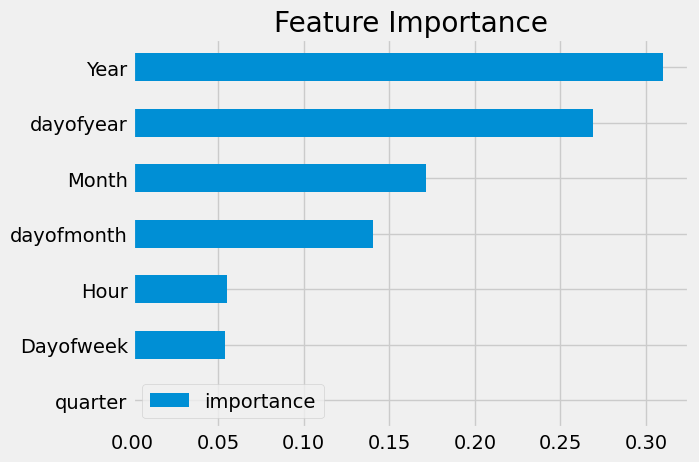

In [90]:
fi = pd.DataFrame(data=reg3.feature_importances_,
             index=reg3.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [91]:
test3['prediction'] = reg3.predict(X_test3)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\1966093399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['prediction'] = reg3.predict(X_test3)


In [93]:
score = np.sqrt(mean_squared_error(test3['press'], test3['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 6.70


In [95]:
test3['error'] = np.abs(test3[TARGET] - test3['prediction'])
test3['date'] = test3.index.date
test3.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\2358788468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['error'] = np.abs(test3[TARGET] - test3['prediction'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_28536\2358788468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['date'] = test3.index.date


date
2015-11-21    25.198147
2015-02-18    24.902349
2016-01-22    23.904319
2015-02-01    23.699181
2015-01-30    23.459517
2016-01-23    22.711123
2015-01-31    22.677674
2015-11-01    22.086123
2016-01-24    21.839580
2015-02-17    20.688182
Name: error, dtype: float64